In [1]:
import bokeh
import datetime
import main as forecast
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import matplotlib.pyplot as plt

# Give a location, return lat/lon

In [3]:
geolocator = Nominatim(user_agent="meteori")
location = geolocator.geocode('Breckenridge, CO')
location.address

'Breckenridge, Summit County, Colorado, 80424, United States of America'

In [4]:
lat, lon = location.latitude, location.longitude+360
date = datetime.datetime.today()

In [5]:
year = date.year
month = f'{date.month:02d}'
# day = f'{date.day:02d}'
day = 20
forecast_start_time = '00'

# Pull remote datasets from OpenDAP server

In [6]:
base_url = 'https://nomads.ncep.noaa.gov:9090/dods/'

dset_paths = {'gefs': f'{base_url}gens/gens{year}{month}{day}/gep_all_{forecast_start_time}z',
              'gefs_0p5': f'{base_url}gens_bc/gens{year}{month}{day}/gep_all_{forecast_start_time}z',
              'gfs_0p25': f'{base_url}gfs_0p25_1hr/gfs{year}{month}{day}/gfs_0p25_1hr_{forecast_start_time}z', }

gefs, gfs, gefs_0p5 = forecast.load_datasets_from_nomads(dset_paths)

# Subsample datasets for just our location

In [7]:
# gefs = forecast.sample_point(lat, lon, gefs, res=1)
# gefs['lat'] = lat
# gefs['lon'] = lon
# gefs = gefs.load()

# gfs = forecast.sample_point(lat, lon, gfs, res=0.25)
# gfs['lat'] = lat
# gfs['lon'] = lon
# gfs = gfs.load()

# gefs_0p5 = forecast.sample_point(lat, lon, gefs_0p5, res=0.5)
# gefs_0p5['lat'] = lat
# gefs_0p5['lon'] = lon
# gefs_0p5 = gefs_0p5.load()

# gfs.to_netcdf('gfs.nc')
# gefs.to_netcdf('gefs.nc')
# gefs_0p5.to_netcdf('gefs_0p5.nc')

In [8]:
gfs = xr.open_dataset('gfs.nc')
gefs = xr.open_dataset('gefs.nc')
gefs_0p5 = xr.open_dataset('gefs_0p5.nc')

# Bias correct the GEFS with the Neural Network

In [9]:
nn_model = forecast.load_nn(path_to_nn_model='./')

In [10]:
gefs = forecast.run_nn(path_to_nn_model='./',gefs=gefs,nn_model=nn_model)

# Calculate a bunch of forecast parameters

In [11]:
gefs_0p5['wnd10m'] = forecast.wind_speed(gefs_0p5['vgrd10m'], gefs_0p5['ugrd10m'])
gfs['wnd10m'] = forecast.wind_speed(gfs['vgrd10m'], gfs['ugrd10m'])
gefs_0p5['app_tmp2m'] = forecast.calculate_app_temp(
    gefs_0p5['wnd10m'], gefs_0p5['tmp2m'], gefs_0p5['dpt2m'])
gfs['app_tmp2m'] = forecast.calculate_app_temp(
    gfs['wnd10m'], gfs['tmp2m'], gfs['dpt2m'])    

ds_out = forecast.calculate_forecast_tmp2m(gefs, gefs_0p5, gfs)

ds_out = forecast.extract_forecast_ovar('wnd10m', ds_out, gfs, gefs_0p5)
ds_out = forecast.extract_forecast_ovar('app_tmp2m', ds_out, gfs, gefs_0p5)
ds_out = forecast.extract_forecast_ovar('dpt2m', ds_out, gfs, gefs_0p5)
ds_out['dpt2m'] = ds_out['dpt2m']-273.15
ds_out['dpt2m_max'] = ds_out['dpt2m_max']-273.15
ds_out['dpt2m_min'] = ds_out['dpt2m_min']-273.15

ds_out = np.round(ds_out,1)

ds_out = forecast.calculate_precip_prob(ds_out, gefs)

for ptype in ['pcticep','pctsnow','pctfrzr','pctrain']:
    ds_out[ptype] = np.round(ds_out[ptype],2)

# Generate JSON file

In [12]:
ds_out['lat'] = lat
ds_out['lon'] = lon

json_output = forecast.to_json(ds_out,gfs)

# Visualize

In [13]:
x = json_output['forecast']['time']
# x = [pd.to_datetime(str(el)) for el in x]

labels = [el[0:10] for el in x[::24]]

Text(0, 0.5, 'Temperature (°C)')

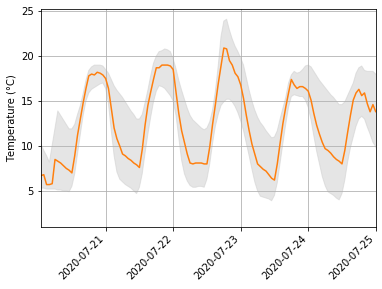

In [17]:
import mpld3

fig = plt.figure()

plt.plot(x,json_output['forecast']['temperature']['best_guess'],color='tab:orange')

plt.fill_between(x=x[1:-1],
                 y1 = json_output['forecast']['temperature']['min_poss'][1:-1],
                 y2 = json_output['forecast']['temperature']['max_poss'][1:-1],
                alpha=0.5,
                color='0.8')

plt.xticks(x[::24],labels,rotation=45,ha='right')
plt.xlim(x[1],x[120])
plt.grid()

ax = plt.gca()
ax.set_ylabel('Temperature (°C)')


In [18]:
mpld3.display(fig)

In [16]:
def get_forecast_nomads(lat, lon, nn_model, date=datetime.datetime.today()):
    """Calculates the Meteori Ensemble Forecast using the NOMADS server

    The "best guess" is the mean of the Meteori neural network 
    downscaled GEFS mean, the NOAA downscaled GEFS mean, and 0.25 
    degree GFS. The spread is the max and min across both the ensembles 
    (NOAA and Metori) and 0.25 degree GFS

    Args:
        lat: latitude (-90 - 90)
        lon: longitude (0-360)
        date: default value is current time, but in theory can pass any 
        date (this data may not be on the server however)

    Returns:
        xarray Dataset containing the best guess ('tmp2m') and forecast
        spread ('tmp2m_max' and 'tmp2m_min')

    """

    year = date.year
    month = f'{date.month:02d}'
    day = f'{date.day:02d}'
    forecast_start_time = '00'

    # currently reading directly from the NOMADs server
    # these should be update to the file locations on S3
    # Probably should read paths from a json file

    base_url = 'https://nomads.ncep.noaa.gov:9090/dods/'

    dset_paths = {'gefs': f'{base_url}gens/gens{year}{month}{day}/gep_all_{forecast_start_time}z',
                  'gefs_0p5': f'{base_url}gens_bc/gens{year}{month}{day}/gep_all_{forecast_start_time}z',
                  'gfs_0p25': f'{base_url}gfs_0p25_1hr/gfs{year}{month}{day}/gfs_0p25_1hr_{forecast_start_time}z', }

    gefs, gfs, gefs_0p5 = load_datasets_from_nomads(dset_paths)

    print('Load Datasets (1/3) \n')

    print('start loading datasets')

    gefs = sample_point(lat, lon, gefs, res=1)
    gefs['lat'] = lat
    gefs['lon'] = lon
    gefs = gefs.load()

    gfs = sample_point(lat, lon, gfs, res=0.25)
    gfs['lat'] = lat
    gfs['lon'] = lon
    gfs = gfs.load()

    gefs_0p5 = sample_point(lat, lon, gefs_0p5, res=0.5)
    gefs_0p5['lat'] = lat
    gefs_0p5['lon'] = lon
    gefs_0p5 = gefs_0p5.load()
    print('finished loading datasets')

    print('Run Neural Network (2/3) \n')
    gefs = run_nn(gefs=gefs,nn_model=nn_model)

    print('Calculating Forecast (3/3) \n')
    # temporary fix (L518-L521)
    # wnd10m and app_tmp2m should be calculated before and read from server
    gefs_0p5['wnd10m'] = wind_speed(gefs_0p5['vgrd10m'], gefs_0p5['ugrd10m'])
    gfs['wnd10m'] = wind_speed(gfs['vgrd10m'], gfs['ugrd10m'])
    gefs_0p5['app_tmp2m'] = calculate_app_temp(
        gefs_0p5['wnd10m'], gefs_0p5['tmp2m'], gefs_0p5['dpt2m'])
    gfs['app_tmp2m'] = calculate_app_temp(
        gfs['wnd10m'], gfs['tmp2m'], gfs['dpt2m'])    

    ds_out = calculate_forecast_tmp2m(gefs, gefs_0p5, gfs)

    ds_out = extract_forecast_ovar('wnd10m', ds_out, gfs, gefs_0p5)
    ds_out = extract_forecast_ovar('app_tmp2m', ds_out, gfs, gefs_0p5)
    ds_out = extract_forecast_ovar('dpt2m', ds_out, gfs, gefs_0p5)
    ds_out['dpt2m'] = ds_out['dpt2m']-273.15
    ds_out['dpt2m_max'] = ds_out['dpt2m_max']-273.15
    ds_out['dpt2m_min'] = ds_out['dpt2m_min']-273.15

    ds_out = np.round(ds_out,1)

    ds_out = calculate_precip_prob(ds_out, gefs)

    for ptype in ['pcticep','pctsnow','pctfrzr','pctrain']:
        ds_out[ptype] = np.round(ds_out[ptype],2)

    ds_out['lat'] = lat
    ds_out['lon'] = lon

    json_output = to_json(ds_out,gfs)

    return json_output